# ENGR 510: Scientific Computing Homework

Due: Friday 10/25 at 11:59pm via Gradescope

In [1]:
import numpy as np
from numpy.typing import ArrayLike
from matplotlib import pyplot as plt
from scipy import integrate

\begin{gather}
    \Theta'' + \gamma \Theta' + \sin(\Theta) = 0 \\
    \gamma = 0.1
\end{gather}

### Exercise 1.a

$\Theta(t)$ by forward Euler

In [2]:
# Define system dynamics
gamma = 0.1
def odefunc(t: float, x: ArrayLike) -> ArrayLike:
    return np.array([x[1], -np.sin(x[0]) - gamma * x[1]])

In [3]:
def solve_ivp_euler(fun: callable, t_span: tuple[float, float], y0: ArrayLike, t_eval: ArrayLike) -> ArrayLike:
    """Forward Euler numerical integration"""
    y = np.zeros((len(y0), len(t_eval)))
    y[:, 0] = y0
    for i, (t, dt) in enumerate(zip(t_eval[:-1], np.diff(t_eval))):
        y[:, i+1] = y[:, i] + fun(t, y[:, i]) * dt
    return y

In [4]:
# Simulate forward Euler
t_span = (0, 10)
dt = 0.01
t_eval = np.arange(t_span[0], t_span[1]+dt, dt)
x0 = np.array([1, 0.1])
x1a = solve_ivp_euler(odefunc, t_span, x0, t_eval)

# Simulate RK45
solution_truth = integrate.solve_ivp(odefunc, t_span, x0, t_eval=t_eval)
x_truth = solution_truth.y

# Check
assert(x1a.shape == (2, 1001))

#######
# TODO: Perform Euler method.
# A1 = ??? ((2, 1001) numpy.ndarray)
#######
A1 = x1a

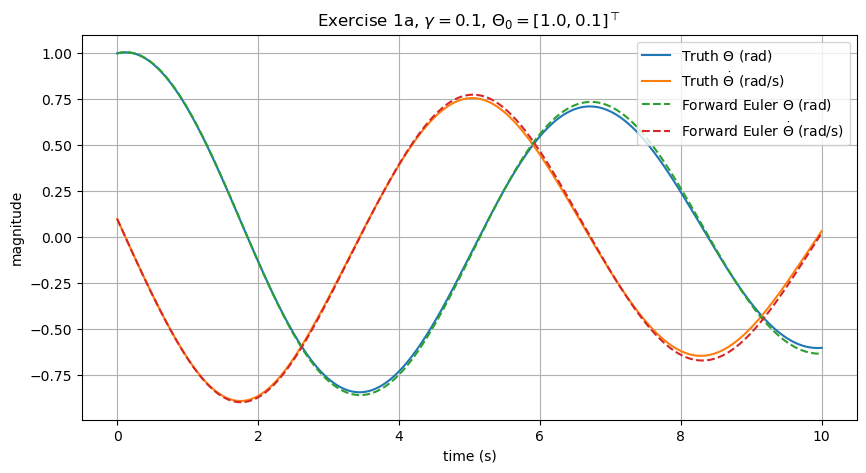

In [5]:
# Plot result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(t_eval, x_truth[0], label='Truth $\Theta$ (rad)')
ax.plot(t_eval, x_truth[1], label='Truth $\dot{\Theta}$ (rad/s)')
ax.plot(t_eval, x1a[0], '--', label='Forward Euler $\Theta$ (rad)')
ax.plot(t_eval, x1a[1], '--', label='Forward Euler $\dot{\Theta}$ (rad/s)')
plt.xlabel('time (s)')
plt.ylabel('magnitude')
plt.title(f'Exercise 1a, $\gamma=0.1$, $\Theta_0=[1.0, 0.1]^\\top$')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 1.b

$\int_{0}^{10} \Theta \ \text{d}t$ by numerically integrating the result of 1.a

In [6]:
def integrate_trapezoid(x: ArrayLike, t: ArrayLike, initial: float=0) -> ArrayLike:
    """Integration by trapezoid method"""
    res = np.zeros(len(x))
    dt_eval = np.diff(t)
    for i, (x, xn, dt) in enumerate(zip(x[:-1], x[1:], dt_eval)):
        res[i+1] = res[i] + 0.5 * dt * (xn + x)
    return res

In [7]:
def integrate_simpson(x: ArrayLike, t: ArrayLike, initial: float=0) -> ArrayLike:
    """Integration by Simpson method"""
    res = np.zeros(int((len(x) - 1) / 2 + 1))
    dt_eval = np.diff(t_eval[::2])
    for i, dt in enumerate(dt_eval):
        res[i+1] = res[i] + dt / 6 * (x[2*i] + 4 * x[2*i+1] + x[2*i+2])
    return res

In [8]:
# Integrate with scipy trapezoidal
scipy_trap_phase = integrate.cumulative_trapezoid(x1a[0], t_eval, initial=0)

# Integrate with my trapezoidal
trap_phase = integrate_trapezoid(x1a[0], t_eval)

# Check
assert(trap_phase.shape == (1001,))
assert(np.allclose(scipy_trap_phase, trap_phase))

# Integrate with scipy Simpson
scipy_simp_phase = integrate.cumulative_simpson(x1a[0], x=t_eval, initial=0)

# Integrate with my Simpson
simp_phase = integrate_simpson(x1a[0], t_eval)

# Check
assert(simp_phase.shape == (501,))
assert(np.allclose(scipy_simp_phase[::2], simp_phase))

#######
# TODO: Apply Trapezoidal rule.
# A2 = ??? ((1001,) numpy.ndarray)
#######
A2 = trap_phase

#######
# TODO: Apply Simpson's rule.
# A3 = ??? ((501,) numpy.ndarray)
#######
A3 = simp_phase

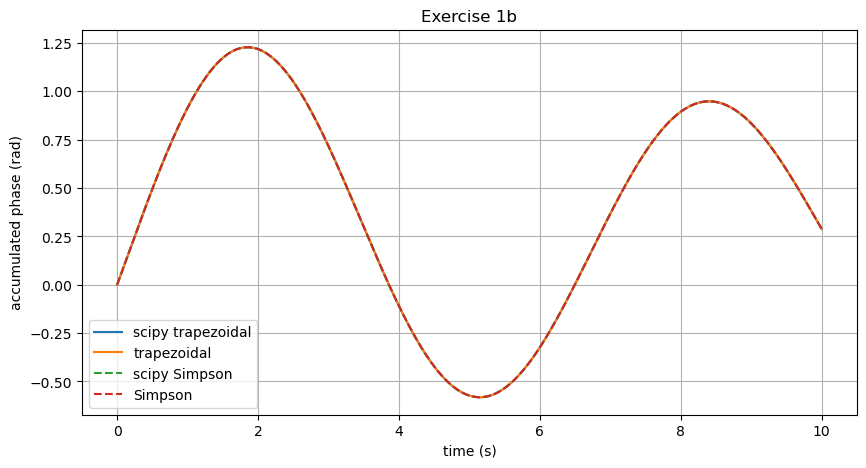

In [9]:
# Plot result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(t_eval, scipy_trap_phase, label='scipy trapezoidal')
ax.plot(t_eval, trap_phase, label='trapezoidal')
ax.plot(t_eval, scipy_simp_phase, '--', label='scipy Simpson')
ax.plot(t_eval[::2], simp_phase, '--', label='Simpson')
plt.xlabel('time (s)')
plt.ylabel('accumulated phase (rad)')
plt.title('Exercise 1b')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 1c

$\ddot{\Theta} (t)$ by numericaly differentiating the angular velocity of 1.a

In [10]:
def fd2(x: ArrayLike, t:ArrayLike) -> ArrayLike:
    """Finite-difference second-order derivative"""
    res = np.zeros(x.shape)
    res[0] = (-3 * x[0] + 4 * x[1] - x[2]) / (t[2] - t[0])
    res[-1] = (3 * x[-1] - 4 * x[-2] + x[-3]) / (t[-1] - t[-3])
    for i in range(1, len(t)-1):
        res[i] = (x[i+1] - x[i-1]) / (t[i+1] - t[i-1])
    return res

In [11]:
def fd4(x: ArrayLike, t:ArrayLike) -> ArrayLike:
    """Finite-difference fourth-order derivative with second-order endpoints"""
    res = np.zeros(x.shape)
    res[0] = (-3 * x[0] + 4 * x[1] - x[2]) / (t[2] - t[0])
    res[1] = (-3 * x[1] + 4 * x[2] - x[3]) / (t[3] - t[1])
    res[-2] = (3 * x[-2] - 4 * x[-3] + x[-4]) / (t[-2] - t[-4])
    res[-1] = (3 * x[-1] - 4 * x[-2] + x[-3]) / (t[-1] - t[-3])
    for i in range(2, len(t)-2):
        res[i] = (-x[i+2] + 8 * x[i+1] - 8 * x[i-1] + x[i-2]) / (3 * (t[i+2] - t[i-2]))
    return res

In [12]:
# Differentiate with 2nd-order scheme
acc2c = fd2(x1a[1], t_eval)

# Check
assert(acc2c.shape == (1001,))

# Differentiate with 4th-order scheme
acc4c = fd4(x1a[1], t_eval)

# Check
assert(acc4c.shape == (1001,))

#######
# TODO: Perform 2nd-order 1st derivative scheme.
# A4 = ??? ((1001,) numpy.ndarray)
#######
A4 = acc2c

#######
# TODO: Perform 4th-order 1st derivative scheme.
# A5 = ??? ((1001,) numpy.ndarray)
#######
A5 = acc4c

### Exercise 1d

$\ddot{\Theta} (t)$ by numerically double differentiating the angular position of 1.a

In [13]:
def fdd4(x: ArrayLike, t: ArrayLike) -> ArrayLike:
    """Finite-difference fourth-order second dervative with second-order endpoints"""
    res = np.zeros(x.shape)
    res[0] = np.dot([2, -5, 4, -1], x[:4]) * 4 / (t[2] - t[0])**2
    res[1] = np.dot([2, -5, 4, -1], x[1:5]) * 4 / (t[3] - t[1])**2
    res[-2] = np.dot([-1, 4, -5, 2], x[-5:-1]) * 4 / (t[-2] - t[-4])**2
    res[-1] = np.dot([-1, 4, -5, 2], x[-4:]) * 4 / (t[-1] - t[-3])**2
    for i in range(2, len(t)-2):
        res[i] = np.dot([-1, 16, -30, 16, -1], x[i-2:i+3]) / (0.75 * (t[i+2] - t[i-2])**2)
    return res

In [14]:
# Double differentiate with 4th-order scheme
acc4d = fdd4(x1a[0], t_eval)

# Check
assert(acc4d.shape == (1001,))

#######
# TODO: Perform 4th-order 2nd derivative scheme.
# A6 = ??? ((1001,) numpy.ndarray)
#######
A6 = acc4d

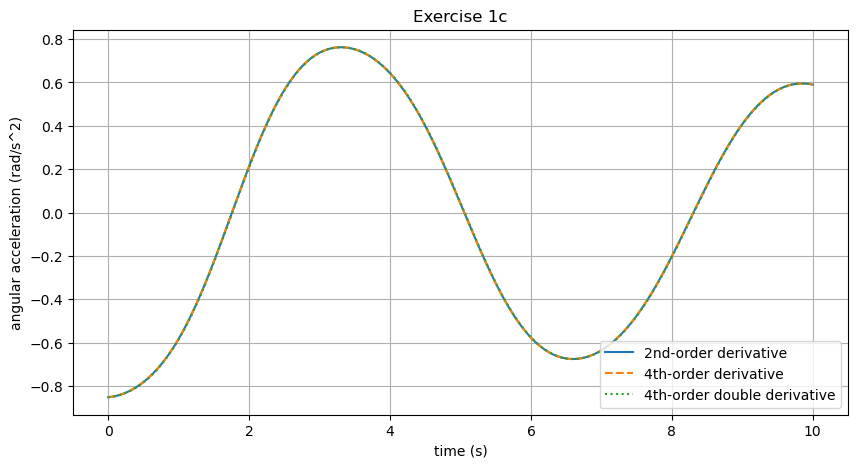

In [15]:
# Plot result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(t_eval, acc2c, label='2nd-order derivative')
ax.plot(t_eval, acc4c, '--', label='4th-order derivative')
ax.plot(t_eval, acc4d, ':', label='4th-order double derivative')
plt.xlabel('time (s)')
plt.ylabel('angular acceleration (rad/s^2)')
plt.title('Exercise 1c')
plt.legend()
plt.grid(True)
plt.show()

## Exercise 1.e

In [16]:
def solve_ivp_adams_bashworth(fun: callable, t_span: tuple[float, float], y0: ArrayLike, y1: ArrayLike, t_eval: ArrayLike) -> ArrayLike:
    """Adams-Bashworth numerical integration"""
    y = np.zeros((len(y0), len(t_eval)))
    y[:, 0] = y0
    y[:, 1] = y1
    for i in range(1, y.shape[1]-1):
        dt = t_eval[i+1] - t_eval[i]
        y[:, i+1] = y[:, i] + 0.5 * dt * (3 * fun(t_eval[i], y[:, i]) - fun(t_eval[i-1], y[:, i-1]))
    return y

In [17]:
# Simulate
x0 = x1a[:, 0]
x1 = x1a[:, 1]
x1e = solve_ivp_adams_bashworth(odefunc, t_span, x0, x1, t_eval)

# Check
assert(x1e.shape == (2, 1001))

#######
# TODO: Perform Adams-Bashforth method.
# A7 = ??? ((2, 1001) numpy.ndarray)
#######
A7 = x1e

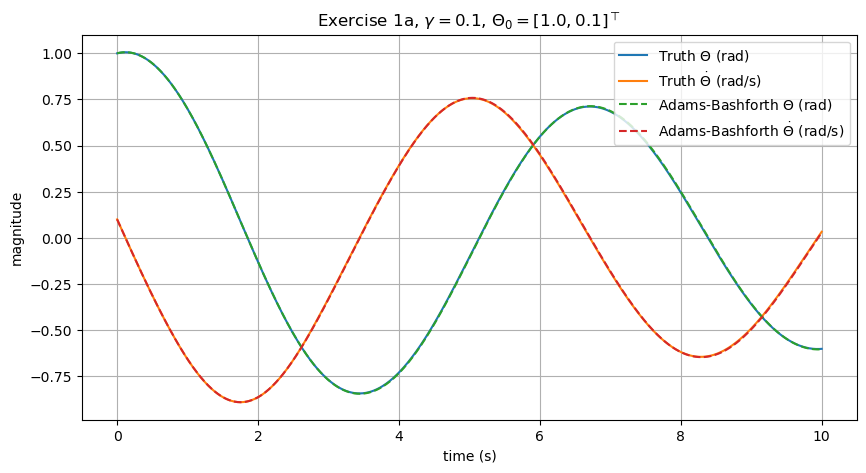

In [18]:
# Plot result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(t_eval, x_truth[0], label='Truth $\Theta$ (rad)')
ax.plot(t_eval, x_truth[1], label='Truth $\dot{\Theta}$ (rad/s)')
ax.plot(t_eval, x1e[0], '--', label='Adams-Bashforth $\Theta$ (rad)')
ax.plot(t_eval, x1e[1], '--',label='Adams-Bashforth $\dot{\Theta}$ (rad/s)')
plt.xlabel('time (s)')
plt.ylabel('magnitude')
plt.title(f'Exercise 1a, $\gamma=0.1$, $\Theta_0=[1.0, 0.1]^\\top$')
plt.legend()
plt.grid(True)
plt.show()

### Exercise 1.f

In [19]:
def solve_ivp_rk2(fun: callable, t_span: tuple[float, float], y0: ArrayLike, y1: ArrayLike, t_eval: ArrayLike) -> ArrayLike:
    """Second-order Runge-Kutta numerical integration"""
    y = np.zeros((len(y0), len(t_eval)))
    y[:, 0] = y0
    y[:, 1] = y1
    for i in range(1, y.shape[1]-1):
        dt = t_eval[i+1] - t_eval[i]
        y[:, i+1] = y[:, i] + dt * fun(t_eval[i] + 0.5 * dt, y[:, i] + 0.5 * dt * fun(t_eval[i], y[:, i]))
    return y

In [20]:
# Simulate
x0 = x1a[:, 0]
x1 = x1a[:, 1]
x1f = solve_ivp_rk2(odefunc, t_span, x0, x1, t_eval)

# Check
assert(x1f.shape == (2, 1001))

#######
# TODO: Perform 2nd-order Runge-Kutta method.
# A8 = ??? ((2, 1001) numpy.ndarray)
#######
A8 = x1f

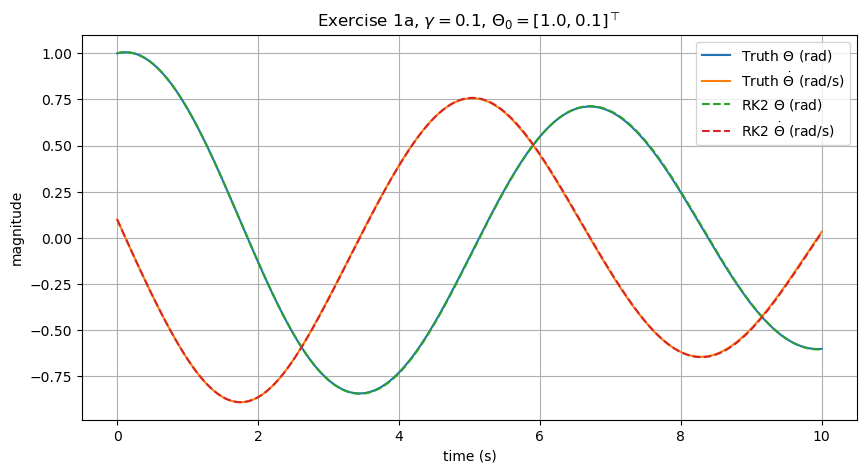

In [21]:
# Plot result
fig = plt.figure(figsize=(10, 5))
ax = plt.subplot()
ax.plot(t_eval, x_truth[0], label='Truth $\Theta$ (rad)')
ax.plot(t_eval, x_truth[1], label='Truth $\dot{\Theta}$ (rad/s)')
ax.plot(t_eval, x1f[0], '--', label='RK2 $\Theta$ (rad)')
ax.plot(t_eval, x1f[1], '--',label='RK2 $\dot{\Theta}$ (rad/s)')
plt.xlabel('time (s)')
plt.ylabel('magnitude')
plt.title(f'Exercise 1a, $\gamma=0.1$, $\Theta_0=[1.0, 0.1]^\\top$')
plt.legend()
plt.grid(True)
plt.show()